<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE32338](https://jckantor.github.io/CBE32338)
by Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE2338.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [TCLab Lab 2: Model Identification](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/02.10-TCLab-Lab-2-Model-Indentification.ipynb) | [Contents](toc.ipynb) | [State Estimation](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/03.00-State-Estimation.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE32338/blob/master/notebooks/02.11-TCLab-Lab-2-Fitting.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE32338/master/notebooks/02.11-TCLab-Lab-2-Fitting.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Model Identification: Fitting models to data

Given the data from an identification experiment, the next task is to find one or more models that accurately reproduce the process response to changes in the manipulated variable. This notebook demonsrates a practical approach to fitting low-order models to step response data.

## Initializations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.integrate import odeint
from scipy.optimize import minimize

### Reading data

The following cell reads previously stored experimental step response data.

In [2]:
df = pd.read_csv("tclab-data.csv")
t = np.array(df["Time"])
T1 = np.array(df["T1"])
T2 = np.array(df["T2"])
Q1 = np.array(df["Q1"])
Q2 = np.array(df["Q2"])

### Plotting function

The following simple data plotting function is used in this notebooke to compare experimental data to model predictions. 

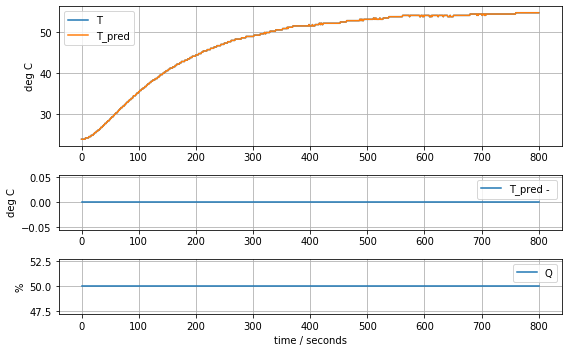

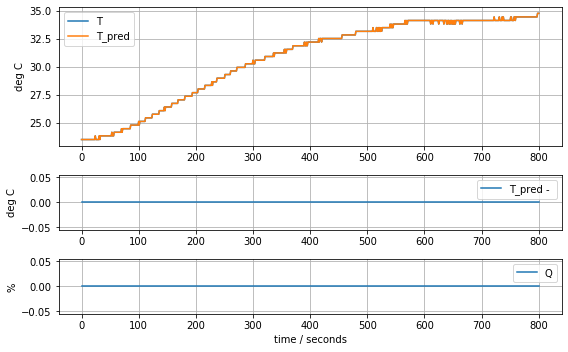

In [3]:
def plot_data(t, T, T_pred, Q):
    
    fig = plt.figure(figsize=(8,5))
    grid = plt.GridSpec(4, 1)
    ax = [fig.add_subplot(grid[:2]), fig.add_subplot(grid[2]), fig.add_subplot(grid[3])]

    ax[0].plot(t, T, t, T_pred)
    ax[0].set_ylabel("deg C")
    ax[0].legend(["T", "T_pred"])
    
    ax[1].plot(t, T_pred - T)
    ax[1].set_ylabel("deg C")
    ax[1].legend(["T_pred - "])
    
    ax[2].plot(t, Q)
    ax[2].set_ylabel("%")
    ax[2].legend(["Q"])
    
    for a in ax: a.grid(True)
    ax[-1].set_xlabel("time / seconds")
    plt.tight_layout()
    
plot_data(t, T1, T1, Q1)
plot_data(t, T2, T2, Q2)

## Empirical Models

Empirical modeling is a process in which we attempt to discover models that accurately describe the input-output behavior of a process without regard to the underlying mechanisms.

### First-order linear model

A first-order transfer function is modeled by the differential equation

$$ \tau \frac{dy}{dt} + y = K u$$

where $y$ is the 'deviation' of the process variable from a nominal steady state, and $u$ is the deviation in manipulated variable from a nominal steady state. For the temperature control lab we will assign the deviation variables as follows:

\begin{align*}
y & = T_1 - T_{ambient} \\
u & = Q_1
\end{align*}

Parameter $K$ is the process gain which can be estimated as the ratio of the a steady-state change in $y$ due to a steady-state change in $u$. Parameter $\tau$ is the first-order 'time constant' which can be estimated as the time to achieve 63.2% of the steady-state change in output to due a steady-state change in $u$.


K = 0.62 tau = 180.0


24.649520390255464

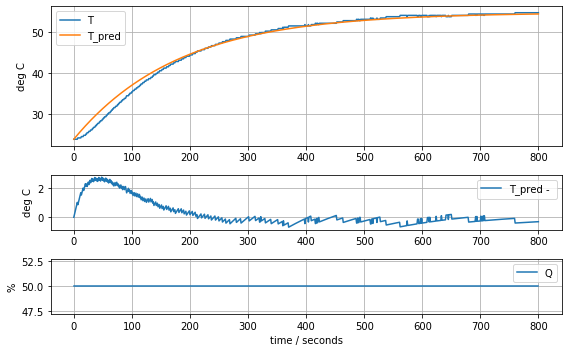

In [4]:
def model_first_order(param, plot=False):
    # access parameter values
    K, tau = param

    # simulation in deviation variables
    u = lambda ti: np.interp(ti, t, Q1)
    def deriv(y, ti):
        dydt  = (K*u(ti) - y)/tau
        return dydt
    y = odeint(deriv, 0, t)[:,0]

    # comparing to experimental data
    T_ambient = T1[0]
    T1_pred = y + T_ambient
    if plot:
        print("K =", K, "tau =", tau)
        plot_data(t, T1, T1_pred, Q1)
    
    return np.linalg.norm(T1_pred - T1)
    
param_first_order = [0.62, 180.0]
model_first_order(param_first_order, plot=True)

K = 0.6370841237049034 tau = 199.8617397701267


20.651093155278453

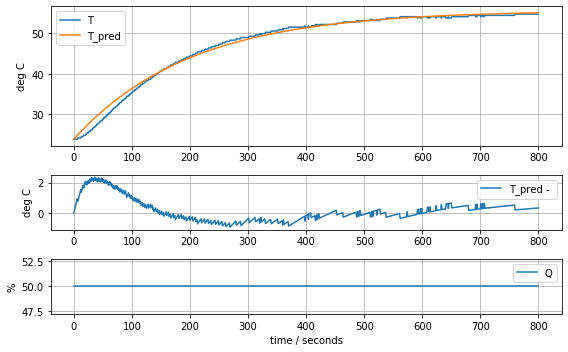

In [5]:
results = minimize(model_first_order, param_first_order, method='nelder-mead')
param_first_order = results.x
model_first_order(param_first_order, plot=True)

### First-order linear model with time delay

The code cell below 

K = 0.62 tau = 160.0 tdelay = 15


16.12137889182889

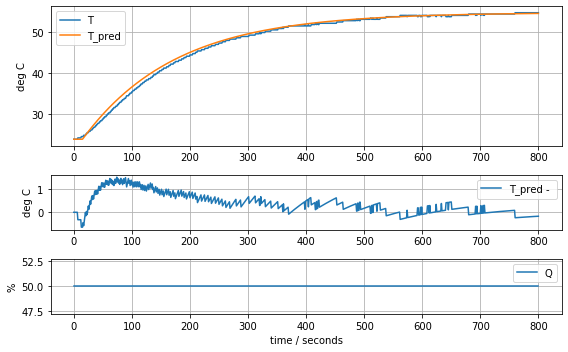

In [6]:
def model_first_order_time_delay(param, plot=False):
    # access parameter values
    K, tau, tdelay = param
    
    # simulation in deviation variables
    u = lambda ti: np.interp(ti, t, Q1, left=0)
    def deriv(y, ti):
        dydt  = (K*u(ti-tdelay) - y)/tau
        return dydt
    y = odeint(deriv, 0, t)[:,0]

    # comparing to experimental data
    T_ambient = T1[0]
    T1_pred = y + T_ambient
    if plot:
        print("K =", K, "tau =", tau, "tdelay =", tdelay)
        plot_data(t, T1, T1_pred, Q1)
    
    return np.linalg.norm(T1_pred - T1)

param_first_order_time_delay = [0.62, 160.0, 15]
model_first_order_time_delay(param_first_order_time_delay, plot=True)

K = 0.6228198545524255 tau = 167.7567962566444 tdelay = 20.18136187851927


6.290512704413097

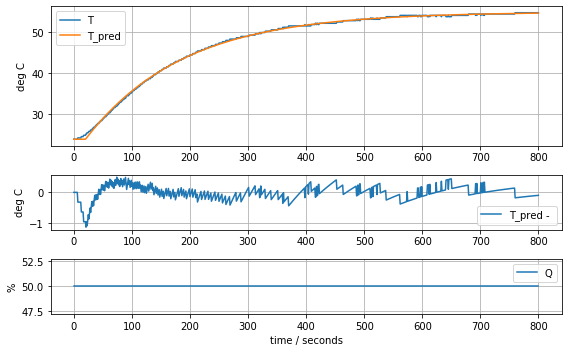

In [7]:
results = minimize(model_first_order_time_delay, param_first_order_time_delay, method='nelder-mead')
param_first_order_time_delay = results.x
model_first_order_time_delay(param_first_order_time_delay, plot=True)

## First-principles modeling

### First-order energy balance for one heater

Assuming the heater/sensor assembly can be described as mass at uniform temperature that exchanges heat with the surrounding results in a first-order linear model.

$$C_p\frac{dT_{1}}{dt} = U_a (T_{amb} - T_{1}) + P Q_1$$

The model can be rearranged into the form of a first order system with time constant $\tau$ and gain $K$

$$\underbrace{\frac{C_p}{U_a}}_{\tau}\underbrace{\frac{d(T_1 - T_{amb})}{dt}}_{\frac{dy}{dt}} + \underbrace{T_1 - T_{amb}}_y = \underbrace{\frac{P}{U_a}}_K \underbrace{Q_1}_u$$

Using the previous results gives estimates for $K$ and $\tau$.

\begin{align*}
K = \frac{P}{U_a} & \implies U_a = \frac{P}{K} = \frac{0.04}{0.62} = 0.065 \text{ watts/deg C} \\
\tau = \frac{C_p}{U_a} & \implies C_p = \tau U_a = \frac{\tau P}{K} = \frac{186 \times 0.04}{0.62} = 12 \text{ J/deg C}
\end{align*}

In [8]:
P = 0.04

K, tau = param_first_order

Ua = P/K
print("Heat transfer coefficient Ua =", Ua, "watts/degree C")

Cp = tau*P/K
print("Heat capacity =", Cp, "J/deg C")

Heat transfer coefficient Ua = 0.06278605683560866 watts/degree C
Heat capacity = 12.548530552470801 J/deg C


Cp = 12.548530552470801 Ua = 0.06278605683560866


20.651088966149587

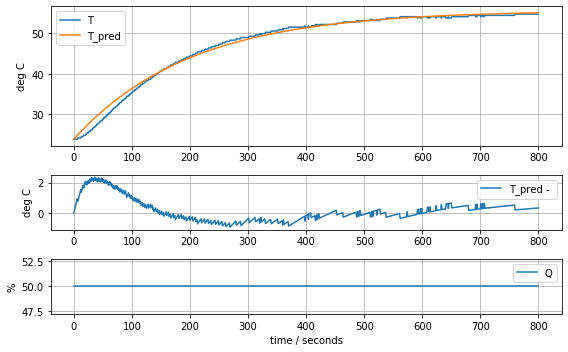

In [9]:
def model_heater(param, plot=False):
    # access parameter values
    T_ambient, Cp, Ua = param
    
    P1 = 0.04

    # simulation in deviation variables
    u = lambda ti: np.interp(ti, t, Q1)
    def deriv(TH1, ti):
        dT1  = (Ua*(T_ambient - TH1) + P1*u(ti))/Cp
        return dT1
    T1_pred = odeint(deriv, T_ambient, t)[:,0]

    # comparing to experimental data
    if plot:
        print("Cp =", Cp, "Ua =", Ua)
        plot_data(t, T1, T1_pred, Q1)
    
    return np.linalg.norm(T1_pred - T1)

param_heater = [T1[0], Cp, Ua]
model_heater(param_heater, plot=True)

Cp = 10.313205580961114 Ua = 0.05862920031801483


10.630933447435487

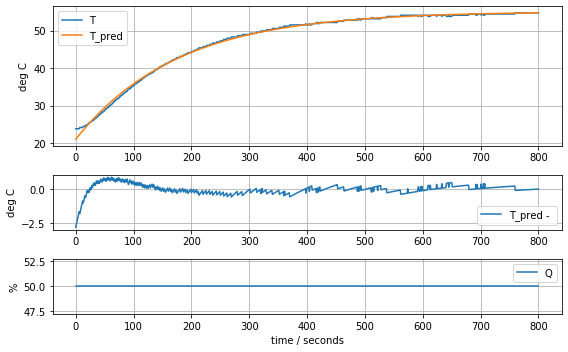

In [10]:
results = minimize(model_heater, param_heater, method='nelder-mead')
param_heater = results.x
model_heater(param_heater, plot=True)

### Two State Model

\begin{align*}
C_p^H \frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_c(T_{S,1} - T_{H,1}) + P_1Q_1 \\
C_p^S \frac{dT_{S,1}}{dt} & = U_c(T_{H,1} - T_{S,1}) 
\end{align*}

[23.81, 12.548530552470801, 2.50970611049416, 0.06278605683560866, 0.06278605683560866]


89.2722844989071

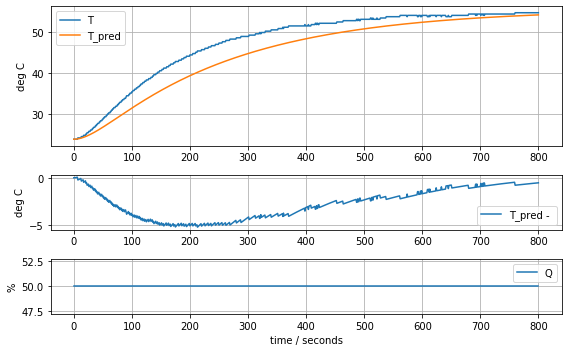

In [11]:
def model_heater_sensor(param, plot=False):
    # access parameter values
    T_ambient, Cp_H, Cp_S, Ua, Uc = param
    
    P1 = 0.04

    # simulation in deviation variables
    u = lambda ti: np.interp(ti, t, Q1)
    def deriv(T, ti):
        T_H1, T_S1 = T
        dT_H1 = (Ua*(T_ambient - T_H1) + Uc*(T_S1 - T_H1) + P1*u(ti))/Cp_H
        dT_S1 = Uc*(T_H1 - T_S1)/Cp_S
        return [dT_H1, dT_S1]
    T1_pred = odeint(deriv, [T_ambient, T_ambient], t)[:,1]

    # comparing to experimental data
    
    if plot:
        print(param)
        plot_data(t, T1, T1_pred, Q1)
    
    return np.linalg.norm(T1_pred - T1)

param_heater_sensor = [T1[0], Cp, Cp/5, Ua, Ua]
model_heater_sensor(param_heater_sensor, plot=True)

[23.71861419  6.88125133  2.74272516  0.06428723  0.07897125]


4.554156209522013

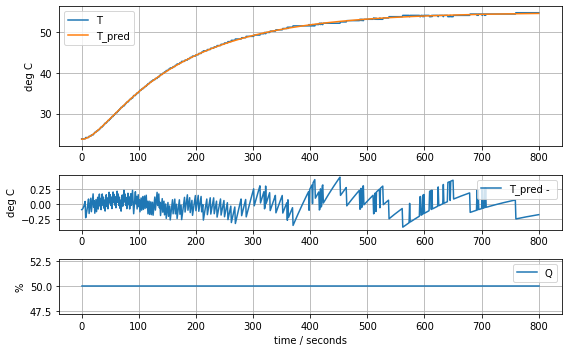

In [12]:
results = minimize(model_heater_sensor, param_heater_sensor, method='nelder-mead')
param_heater_sensor = results.x
model_heater_sensor(param_heater_sensor, plot=True)

## Two heater, four state model

\begin{align*}
C_p^H \frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{H,2} - T_{H,1}) + U_c(T_{S,1} - T_{H,1}) + P_1Q_1 \\
C_p^S \frac{dT_{S,1}}{dt} & = U_c(T_{H,1} - T_{S,1}) \\
C_p^H \frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{H,1} - T_{H,2}) + U_c(T_{S,2} - T_{H,2}) + P_2Q_2 \\
C_p^S \frac{dT_{S,2}}{dt} & = U_c(T_{H,2} - T_{S,2}) 
\end{align*}

[23.81, 12.548530552470801, 2.50970611049416, 0.06278605683560866, 0.06278605683560866, 0.06278605683560866]


143.87441921309681

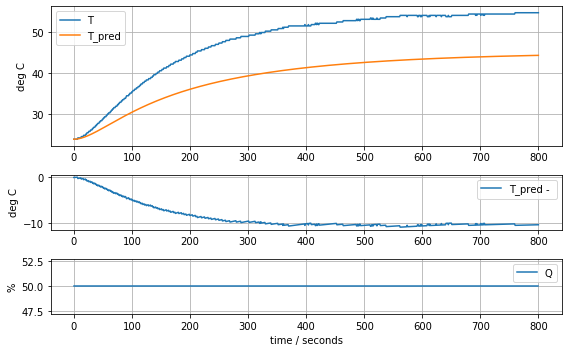

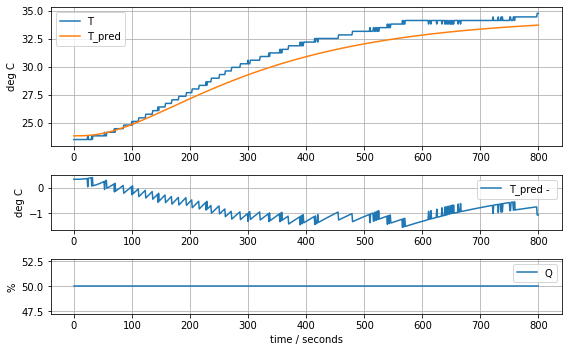

In [13]:
def model_complete(param, plot=False):
    # access parameter values
    T_ambient, Cp_H, Cp_S, Ua, Ub, Uc = param
    
    P1 = 0.04

    # simulation in deviation variables
    u = lambda ti: np.interp(ti, t, Q1)
    def deriv(T, ti):
        T_H1, T_S1, T_H2, T_S2 = T
        dT_H1 = (Ua*(T_ambient - T_H1) + Ub*(T_H2 - T_H1) + Uc*(T_S1 - T_H1) + P1*u(ti))/Cp_H
        dT_S1 = Uc*(T_H1 - T_S1)/Cp_S
        dT_H2 = (Ua*(T_ambient - T_H2) + Ub*(T_H1 - T_H2) + Uc*(T_S2 - T_H2))/Cp_H
        dT_S2 = Uc*(T_H2 - T_S2)/Cp_S
        return [dT_H1, dT_S1, dT_H2, dT_S2]
    T_pred = odeint(deriv, [T_ambient, T_ambient, T_ambient, T_ambient], t)
    T1_pred = T_pred[:,1]
    T2_pred = T_pred[:,3]

    # comparing to experimental data
    if plot:
        print(param)
        plot_data(t, T1, T1_pred, Q1)
        plot_data(t, T2, T2_pred, Q1)
    
    return (np.linalg.norm(T1_pred - T1) + np.linalg.norm(T2_pred - T2))/2

param_complete = [T1[0], Cp, Cp/5, Ua, Ua, Ua]
model_complete(param_complete, plot=True)

[23.60707391  6.92707544  1.61783224  0.04676309  0.02633501  0.04303801]


4.441799745669341

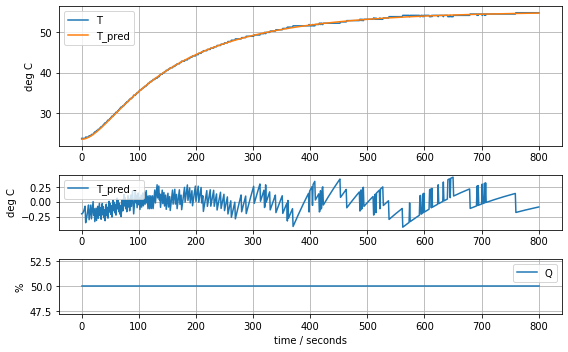

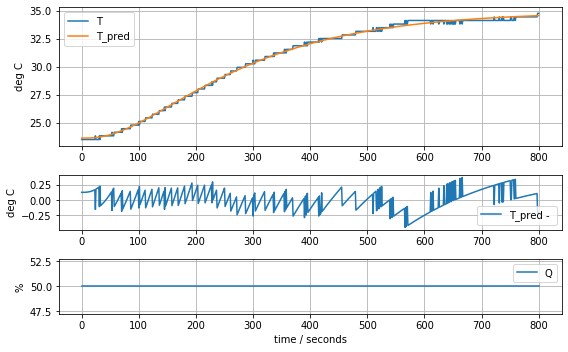

In [14]:
results = minimize(model_complete, param_complete, method='nelder-mead')
param_complete = results.x
model_complete(param_complete, plot=True)

## Consequences 

[23.60707391  6.92707544  1.61783224  0.04676309  0.02633501  0.04303801]


4.441799745669341

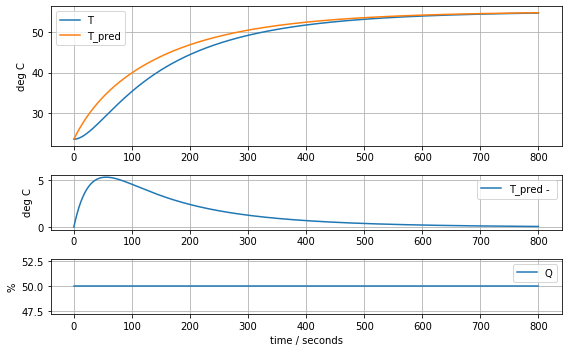

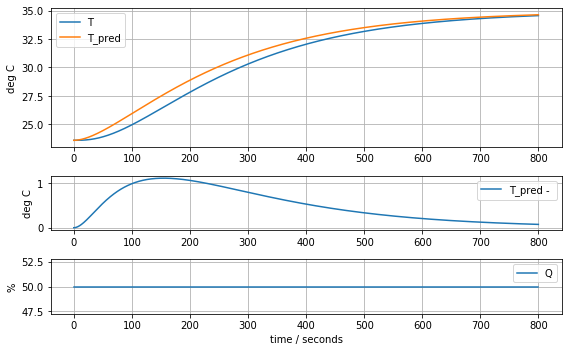

In [15]:
def model_complete(param, plot=False):
    # access parameter values
    T_ambient, Cp_H, Cp_S, Ua, Ub, Uc = param
    
    P1 = 0.04

    # simulation in deviation variables
    u = lambda ti: np.interp(ti, t, Q1)
    def deriv(T, ti):
        T_H1, T_S1, T_H2, T_S2 = T
        dT_H1 = (Ua*(T_ambient - T_H1) + Ub*(T_H2 - T_H1) + Uc*(T_S1 - T_H1) + P1*u(ti))/Cp_H
        dT_S1 = Uc*(T_H1 - T_S1)/Cp_S
        dT_H2 = (Ua*(T_ambient - T_H2) + Ub*(T_H1 - T_H2) + Uc*(T_S2 - T_H2))/Cp_H
        dT_S2 = Uc*(T_H2 - T_S2)/Cp_S
        return [dT_H1, dT_S1, dT_H2, dT_S2]
    T_pred = odeint(deriv, [T_ambient, T_ambient, T_ambient, T_ambient], t)
    T1_pred = T_pred[:,1]
    T2_pred = T_pred[:,3]

    # comparing to experimental data
    if plot:
        print(param)
        plot_data(t, T_pred[:,1], T_pred[:,0], Q1)
        plot_data(t, T_pred[:,3], T_pred[:,2], Q1)
    
    return (np.linalg.norm(T1_pred - T1) + np.linalg.norm(T2_pred - T2))/2

model_complete(param_complete, plot=True)

## State-Space Model

Recalling the model equations

\begin{align*}
C_p^H \frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{H,2} - T_{H,1}) + U_c(T_{S,1} - T_{H,1}) + P_1Q_1 \\
C_p^S \frac{dT_{S,1}}{dt} & = U_c(T_{H,1} - T_{S,1}) \\
C_p^H \frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{H,1} - T_{H,2}) + U_c(T_{S,2} - T_{H,2}) + P_2Q_2 \\
C_p^S \frac{dT_{S,2}}{dt} & = U_c(T_{H,2} - T_{S,2}) 
\end{align*}

Normalizing the derivatives

\begin{align*}
C_p^H \frac{dT_{H,1}}{dt} & = -(U_a + U_b + U_c)T_{H,1} + U_c T_{S,1} + U_b T_{H,2} + U_a T_{amb} + P_1Q_1 \\
C_p^S \frac{dT_{S,1}}{dt} & = U_c T_{H,1} - U_c T_{S,1}) \\
C_p^H \frac{dT_{H,2}}{dt} & = U_b T_{H,1} - (U_a + U_b + U_c) T_{H,2} + U_c T_{S,2} + U_aT_{amb} + P_2Q_2 \\
C_p^S \frac{dT_{S,2}}{dt} & = U_c T_{H,2} - U_c T_{S,2}
\end{align*}

Gathering terms on the right hand side

\begin{align*}
 \frac{dT_{H,1}}{dt} & = -\frac{(U_a + U_b + U_c)}{C_p^H} T_{H,1} + \frac{U_c}{C_p^H} T_{S,1} + \frac{U_b}{C_p^H} T_{H,2} + \frac{U_a}{C_p^H} T_{amb} + \frac{P_1}{C_p^H} Q_1 \\
\frac{dT_{S,1}}{dt} & = \frac{U_c}{C_p^S} T_{H,1} - \frac{U_c}{C_p^S} T_{S,1} \\
\frac{dT_{H,2}}{dt} & = \frac{U_b}{C_p^H} T_{H,1} - \frac{(U_a + U_b + U_c)}{C_p^H} T_{H,2} + \frac{U_c}{C_p^H} T_{S,2} + \frac{U_a}{C_p^H} T_{amb} + \frac{P_2}{C_p^H} Q_2 \\
\frac{dT_{S,2}}{dt} & = \frac{U_c}{C_p^S} T_{H,2} - \frac{U_c}{C_p^S} T_{S,2}
\end{align*}

State space model

$$ \underbrace{\begin{bmatrix} \frac{dT_{H,1}}{dt} \\ \frac{dT_{S,1}}{dt} \\ \frac{T_{H,2}}{dt} \\ \frac{T_{S,2}}{dt} \end{bmatrix}}_{\frac{dx}{dt}} = \underbrace{\begin{bmatrix} -\frac{(U_a + U_b + U_c)}{C_p^H} & \frac{U_c}{C_p^H} & \frac{U_b}{C_p^H} & 0 \\ \frac{U_c}{C_p^S} & - \frac{U_c}{C_p^S} & 0 & 0 \\  \frac{U_b}{C_p^H} & 0 & - \frac{(U_a + U_b + U_c)}{C_p^H} & \frac{U_c}{C_p^H} \\  0 & 0 & \frac{U_c}{C_p^S} & - \frac{U_c}{C_p^S} \end{bmatrix}}_A
\underbrace{\begin{bmatrix} T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2} \end{bmatrix}}_x + \underbrace{\begin{bmatrix} \frac{P_1}{C_p^H} & 0 \\ 0 & 0 \\ 0 & \frac{P_2}{C_p^H} \\ 0 & 0 \end{bmatrix}}_B \underbrace{\begin{bmatrix} Q_1 \\ Q_2 \end{bmatrix}}_u + \underbrace{\begin{bmatrix} \frac{U_a}{C_p^H} \\ 0 \\ \frac{U_a}{C_p^H} \\ 0 \end{bmatrix}}_E \underbrace{T_{amb}}_d$$

$$\underbrace{\begin{bmatrix} T_1 \\ T_2 \end{bmatrix}}_y = \underbrace{\begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_C \underbrace{\begin{bmatrix} T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2} \end{bmatrix}}_x + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0\end{bmatrix}}_D \underbrace{\begin{bmatrix} Q_1 \\ Q_2 \end{bmatrix}}_u$$

Matrix/vector formulation

\begin{align*}
\frac{dx}{dt} & = A x + B u + E d \\
y & = C x + D u
\end{align*}

In [29]:
P1 = 0.04
P2 = 0.02

T_ambient, Cp_H, Cp_S, Ua, Ub, Uc = param_complete

A = np.array([[-(Ua + Ub + Uc)/Cp_H, Uc/Cp_H, Ub/Cp_H, 0],
     [Uc/Cp_S, -Uc/Cp_S, 0, 0],
     [Ub/Cp_H, 0, -(Ua + Ub + Uc)/Cp_H, Uc/Cp_H],
     [0, 0, Uc/Cp_S, -Uc/Cp_S]])

B = np.array([[P1/Cp_H, 0], [0, 0], [0, P2/Cp_H], [0, 0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

D = np.array([[0, 0], [0, 0]])

E = np.array([[Ua/Cp_H], [0], [Ua/Cp_H], [0]])

Time constants

In [30]:
eval, evec = np.linalg.eig(A)
-1/eval

array([191.1942343 ,  96.34592497,  27.18108829,  29.12414895])

In [31]:
evec

array([[ 0.44286448, -0.36815989, -0.25289296, -0.19739009],
       [ 0.551245  , -0.60370381,  0.66033715,  0.67899717],
       [ 0.44286448,  0.36815989,  0.25289296, -0.19739009],
       [ 0.551245  ,  0.60370381, -0.66033715,  0.67899717]])

## Putting to work

In [32]:
from control import *
from control.matlab import *


In [33]:
ss = StateSpace(A, B, C, D)

In [34]:
ss

A = [[-0.01676553  0.00621301  0.00380175  0.        ]
 [ 0.02660227 -0.02660227  0.          0.        ]
 [ 0.00380175  0.         -0.01676553  0.00621301]
 [ 0.          0.          0.02660227 -0.02660227]]

B = [[0.00577444 0.        ]
 [0.         0.        ]
 [0.         0.00288722]
 [0.         0.        ]]

C = [[0. 1. 0. 0.]
 [0. 0. 0. 1.]]

D = [[0. 0.]
 [0. 0.]]

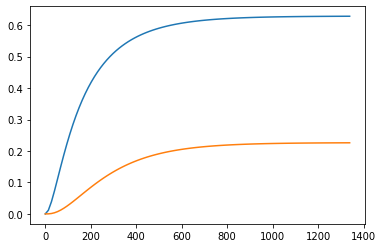

In [40]:
y,t = step(ss, input=0)
plt.plot(t,y)

In [42]:
pole(ss)

array([-0.00523028, -0.01037927, -0.03679029, -0.03433577])

In [23]:
tf(ss,)


Input 1 to output 1:
          0.0001536 s^2
---------------------------------
s^4 + 0.03957 s^3 + 0.0001796 s^2

Input 1 to output 2:
                  5.84e-07 s + 1.554e-08
----------------------------------------------------------
s^4 + 0.08674 s^3 + 0.002428 s^2 + 2.358e-05 s + 6.858e-08

Input 2 to output 1:
          7.681e-05 s^2
---------------------------------
s^4 + 0.03957 s^3 + 0.0001796 s^2

Input 2 to output 2:
          7.681e-05 s^2 + 3.331e-06 s + 2.156e-08
----------------------------------------------------------
s^4 + 0.08674 s^3 + 0.002428 s^2 + 2.358e-05 s + 6.858e-08

<!--NAVIGATION-->
< [TCLab Lab 2: Model Identification](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/02.10-TCLab-Lab-2-Model-Indentification.ipynb) | [Contents](toc.ipynb) | [State Estimation](http://nbviewer.jupyter.org/github/jckantor/CBE32338/blob/master/notebooks/03.00-State-Estimation.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE32338/blob/master/notebooks/02.11-TCLab-Lab-2-Fitting.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE32338/master/notebooks/02.11-TCLab-Lab-2-Fitting.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>